In [101]:
%load_ext autoreload
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [102]:
import sys
sys.path.append('src')
from poisson_disk import PoissonDiskSampler
%aimport settings
import settings
%aimport cnn_utils
import cnn_utils
%aimport geometry_utils
import geometry_utils
%aimport dataset_utils
import dataset_utils

import numpy as np
import cv2
import matplotlib
import matplotlib.pylab as plt
sys.path.append(settings.CAFFE_PYTHON_PATH)
import caffe
%matplotlib inline

In [3]:
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [103]:
cub = dataset_utils.CUB_200_2011()
cub_annotations = dataset_utils.BerkeleyAnnotaionHelper(cub)
IDtrain, IDtest = cub.train_test_id()
imgs_addr = cub.image_addrs()

dh = cnn_utils.DeepHelper()

6


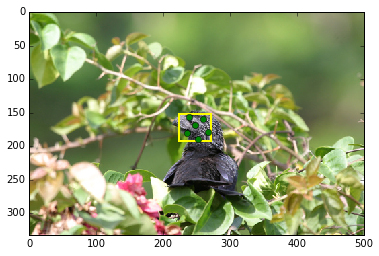

In [104]:
part = 'head'
radius = 15
fig = plt.figure()
ax = fig.add_subplot(111)

img_id = IDtrain[95]

img = caffe.io.load_image(imgs_addr[img_id])
box = cub_annotations.annotation(img_id, part)

dh.init_with_image(img)

positive_points = box.generate_points_inside(param=radius, img=img)

geometry_utils.draw_points(positive_points, ax, color='green')
print len(positive_points)
ax.imshow(box.draw_box(img, (1, 1, 0)))

68


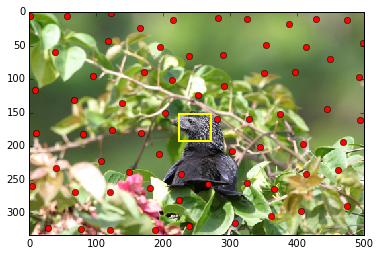

In [105]:
part = 'head'
radius = 40
fig = plt.figure()
ax = fig.add_subplot(111)

img_id = IDtrain[95]

img = caffe.io.load_image(imgs_addr[img_id])
box = geometry_utils.Box.box_from_img(img)
box_head = cub_annotations.annotation(img_id, part)

dh.init_with_image(img)

negative_points = box.generate_points_inside(param=radius, img=img)
negative_points = geometry_utils.filter_points(negative_points, box_head)

geometry_utils.draw_points(negative_points, ax, color='red')
print len(negative_points)
ax.imshow(box_head.draw_box(img, (1, 1, 0)))

In [107]:
def image_features(img_id, part, part_radius, box_radius, ax):
    img = caffe.io.load_image(imgs_addr[img_id])
    box = geometry_utils.Box.box_from_img(img)
    box_part = cub_annotations.annotation(img_id, part)
    dh.init_with_image(img)
    
    positive_points = box_part.generate_points_inside(param=part_radius)
    
    negative_points = box.generate_points_inside(param=box_radius, img=img)
    negative_points = geometry_utils.filter_points(negative_points, box_part)
    
    geometry_utils.draw_points(positive_points, ax, color='green')
    geometry_utils.draw_points(negative_points, ax, color='red')
    
    ax.imshow(box_part.draw_box(img, (1, 1, 0)))
    
    print len(positive_points), len(negative_points)

6 93


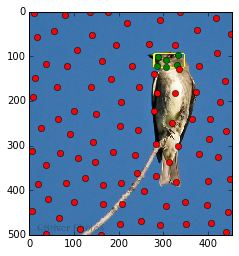

In [110]:
fig = plt.figure()
ax = fig.add_subplot(111)

image_features(IDtrain[1195], 'head', 15, 40, ax)

In [115]:
img_id = IDtrain[1195]
part = 'head'
part_box = cub_annotations.annotation(img_id, part)
img = caffe.io.load_image(imgs_addr[img_id])
pos, neg = dh.image_point_features(img, part_box, part)

In [116]:
pos.shape, neg.shape

((8, 1376), (89, 1376))